In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Import libraries

In [ ]:
import numpy as np
import pandas

# text processing libraries
import re
import string
import nltk
from nltk.corpus import stopwords

# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn import model_selection
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import os
 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
print('Training data shape: ', train.shape)
train.head()

# 2. EDA

##### colums
- id - 각 트윗의 고유 번호
- text - 트윗 내용
- location - 트윗을 보낸 위치 (비어 있을 수도 있음)
- keyword - 트윗의 특정 키워드 (비어 있을 수도 있음)
- target - 오직 train.csv에만 있음, target은 트윗이 진짜 재난에 관한 트윗인지 나타냄. real disaster (1) or not (0)

In [ ]:
test = pd.read_csv('../input/nlp-getting-started/test.csv')
print('Testing data shape: ', test.shape)
test.head()

#### a) 결측치 분석 ####

- 트윗 내용
- 트윗을 보낸 위치
- 트윗의 특정 키워드

In [ ]:
train.isnull().sum()

In [ ]:
test.isnull().sum()

> train set과 test set 모두 location에서 많은 결측치를 확인할 수 있다.

#### b) Target 열 탐색 ####

In [ ]:
train['target'].value_counts()

In [ ]:
sns.barplot(train['target'].value_counts().index, train['target'].value_counts(), palette='rocket')

> 0: fake disaster tweet / 1: real disaster tweet

- 데이터셋 안의 트윗 내용을 살펴보자

In [ ]:
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

In [ ]:
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

> 실제 재난 트윗은 재난과 관련된 내용인 것을 확인

#### c) keyword 열 탐색 ####

- 트윗에서 나온 키워드 상위 20개를 살펴보며, 재난과 관련 있는 키워드가 있는지 확인해보자.

In [ ]:
train['keyword'].value_counts()[:20].index

value_counts().index를 사용하면 데이터의 종류, 즉 키워드의 종류를 알 수 있다.

In [ ]:
train['keyword'].value_counts()[:20]

value_counts()를 사용하면 데이터의 도수, 즉 키워드 별 도수를 알 수 있다.

In [ ]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,
            x=train['keyword'].value_counts()[:20],
            orient='h')

> fatalites(사망자), deluge(대홍수), sinking(침몰), damage(손해) 등 상위 5개의 키워드만 살펴봐도 재난과 관련된 키워드가 4개나 된다.

#### d) location 열 탐색 ####

- location 열은 결측치가 많이 있지만 상위 20개의 트윗을 보낸 위치를 확인해보자.

In [ ]:
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                           "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,
            x=train['location'].value_counts()[:5],
            orient='h')

> 트윗을 보낸 위치로는 미국, 영국, 아프리카, 인도 등이 있다. 

# 3. Text Data Preprocessing

#### 1. Data Cleaning

In [ ]:
train['text'][0:20]

> 문장을 살펴보면 구두점, 특수문자, 대문자와 소문자의 혼합 등 노이즈가 많은 것을 확인할 수 있다.

#### 노이즈 제거

정규 표현식(Regular Expressions, re)은 특정한 규칙을 가진 문자열의 집합을 표현하는 데 사용하는 형식 언어이다.  
정규 표현식은 '패턴 매칭 기능을 제공하는데, 특정 패턴과 일치하는 문자열을 검색, 추출, 치환할 수 있는 기능을 말한다.  
즉, 반복문이나 조건문없이 패턴을 가진 문장의 검색, 추출, 치환을 할 수 있다.  
따라서 특정 문자열을 찾고 싶을 때나 특정 문자열을 대체하고 싶을 때 주로 정규 표혁식을 사용한다.   



re 라이브러리를 import 해서 정규 표현식의 패턴 매칭 기능을 이용해 문장 내 노이즈를 제거해보자.  

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train['text'] = train['text'].apply(lambda x: clean_text(x))
test['text'] = test['text'].apply(lambda x: clean_text(x))

train['text'][0:20]

문장의 특수기호를 모두 대체했다.

 #### 2. Tokenization ####

주어진 문장 내 토큰(token)이라고 불리는 단위로 나누는 작업을 토큰화(tokenization)이라고 한다.  
토큰의 단위는 상황에 따라 다르지만, 보통 의미있는 단위로 토큰을 정의한다.  
여기서는 단어 단위로 토큰화를 해보자.

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['text'] = train['text'].apply(lambda x: tokenizer.tokenize(x))
test['text'] = test['text'].apply(lambda x: tokenizer.tokenize(x))

train['text'].head()

#### 3. Stopwords Removal #### 

갖고 있는 문장에서 유의미한 단어 토큰만을 선별하기 위해서는 큰 의미가 없는 단어 토큰을 제거하는 작업이 필요하다.  
여기서 큰 의미가 없는 단어를 불용어(Stopwords)라고 하고 예를 들어 I, my, me, over 등이 있다.  
nltk에서는 불용어를 패키지 내에 미리 정의하고 있어 nltk를 이용해 불용어를 제거해보자.  

In [ ]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train['text'] = train['text'].apply(lambda x: remove_stopwords(x))
test['text'] = test['text'].apply(lambda x: remove_stopwords(x))
train.head()

#### 4. Token normalization ####


토큰 정규화(Token normalization)는 표현 방법이 다른 단어들을 통합시켜서 같은 단어로 만들어주는 작업이다.

In [ ]:
def combine_text(list_of_text):
    combined_text = ' '.join(list_of_text)
    return combined_text

train['text'] = train['text'].apply(lambda x: combine_text(x))
test['text'] = test['text'].apply(lambda x: combine_text(x))
train.head()

In [ ]:
def text_preprocessing(text):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    
    nopunc = clean_text(text)
    tokenized_text = tokenizer.tokenize(nopunc)
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    combined_text = ' '.join(remove_stopwords)
    return combined_text

train.head()

#### 5. Transforming tokens to a vector

문장 내 단어 토큰을 벡터로 변환하는 벡터화(Vectorize) 작업을 해보자.  
이 벡터화는 자연어를 컴퓨터가 이해할 수 있는 벡터 형식으로 변환하는 과정이다.    

토큰을 벡터로 변환하는 방법은 다양하다.    

**1) 등장 횟수 기반의 단어 표현(Count-based Representation)**     
첫 번째로 등장 횟수를 기반으로 단어를 표현할 수 있다. 단어가 문장에 등장하는 횟수로 벡터화를 한다.   
- Bag-of-Words
- TF-IDF

**2) 분포 기반의 단어 표현(Distributed Representation)**     
그리고 분포를 기반으로 단어를 표현할 수 있다. 타켓 단어 주변 단어를 벡터화 한다.
- Word2Vec
    - Glove
    - fastText

#### a) Bag of Words: Countvectorizer Features ####

먼저 Bag of Words를 알아보자.  
Bag of Words는 단어들의 순서는 고려하지 않고, 단어들의 출현 빈도수를 파악하여 토큰을 벡터로 변환한다.

In [ ]:
count_vectorizer = CountVectorizer()
train_vectors = count_vectorizer.fit_transform(train['text'])
test_vectors = count_vectorizer.transform(test['text'])

print(train_vectors[0].todense())

#### b) TFIDF Features ####

TF-IDF(Term Frequency-Inverse Document Frequency)는 단어의 빈도와 역 문서 빈도를 사용하여 각 단어들마다 중요한 정도를 가중치로 주는 방법이다.

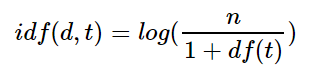

위에 있는 식이 TF-IDF에서 사용하는 가중치 공식이다.  
여기서 df는 특정 단어가 등장한 문장의 개수, N은 문장의 총 개수를 의미한다. 

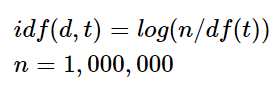  
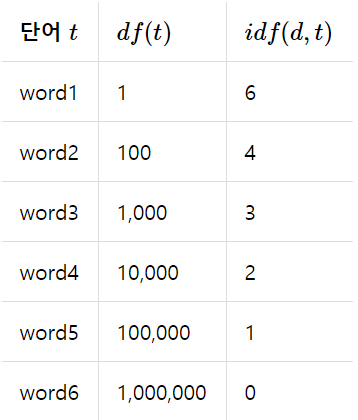

특정 단어가 각 문서, 또는 전체 문장들에서 몇 번 등장했는지는 관심을 가지지 않으며 오직 특정 단어가 등장한 문장의 개수에만 관심을 가진다.  
예를 들어 the와 같은 단어는 전체 문장에서 거의 한 번씩은 등장하는데 이렇게 거의 모든 문장에 등장한다는 것은 분별력을 가지기 어려운 단어라는 것이기 때문에 가중치를 낮게 할당하는 것이다. 

In [ ]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1, 2))
train_tfidf = tfidf.fit_transform(train['text'])
test_tfidf = tfidf.transform(test["text"])

# 4. Building a Text Classification model

#### 1) Logistic Regression Classifier

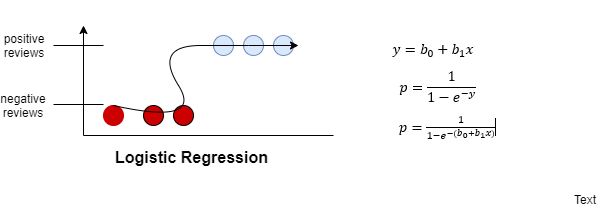

In [ ]:
clf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf, train_vectors, train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf.fit(train_vectors, train["target"])

In [ ]:
clf_tfidf = LogisticRegression(C=1.0)
scores = model_selection.cross_val_score(clf_tfidf, train_tfidf, train["target"], cv=5, scoring="f1")
scores

> 해당 모델의 score 값을 출력해 확인해 보았다. 다른 모델과 정확도 비교를 해보자

#### 2) Naives Bayes Classifier
나이브 베이즈 알고리즘은 지도학습의 일종으로, 스팸 메일 필터, 텍스트 분류, 감정 분석, 추천 시스템 등에 주로 사용되는 알고리즘이다. 베이즈 정리라는 조건부 확률을 계산하는 알고리즘에 기반해서 텍스트 분류를 수행하는 통계적 분류 기법이다.

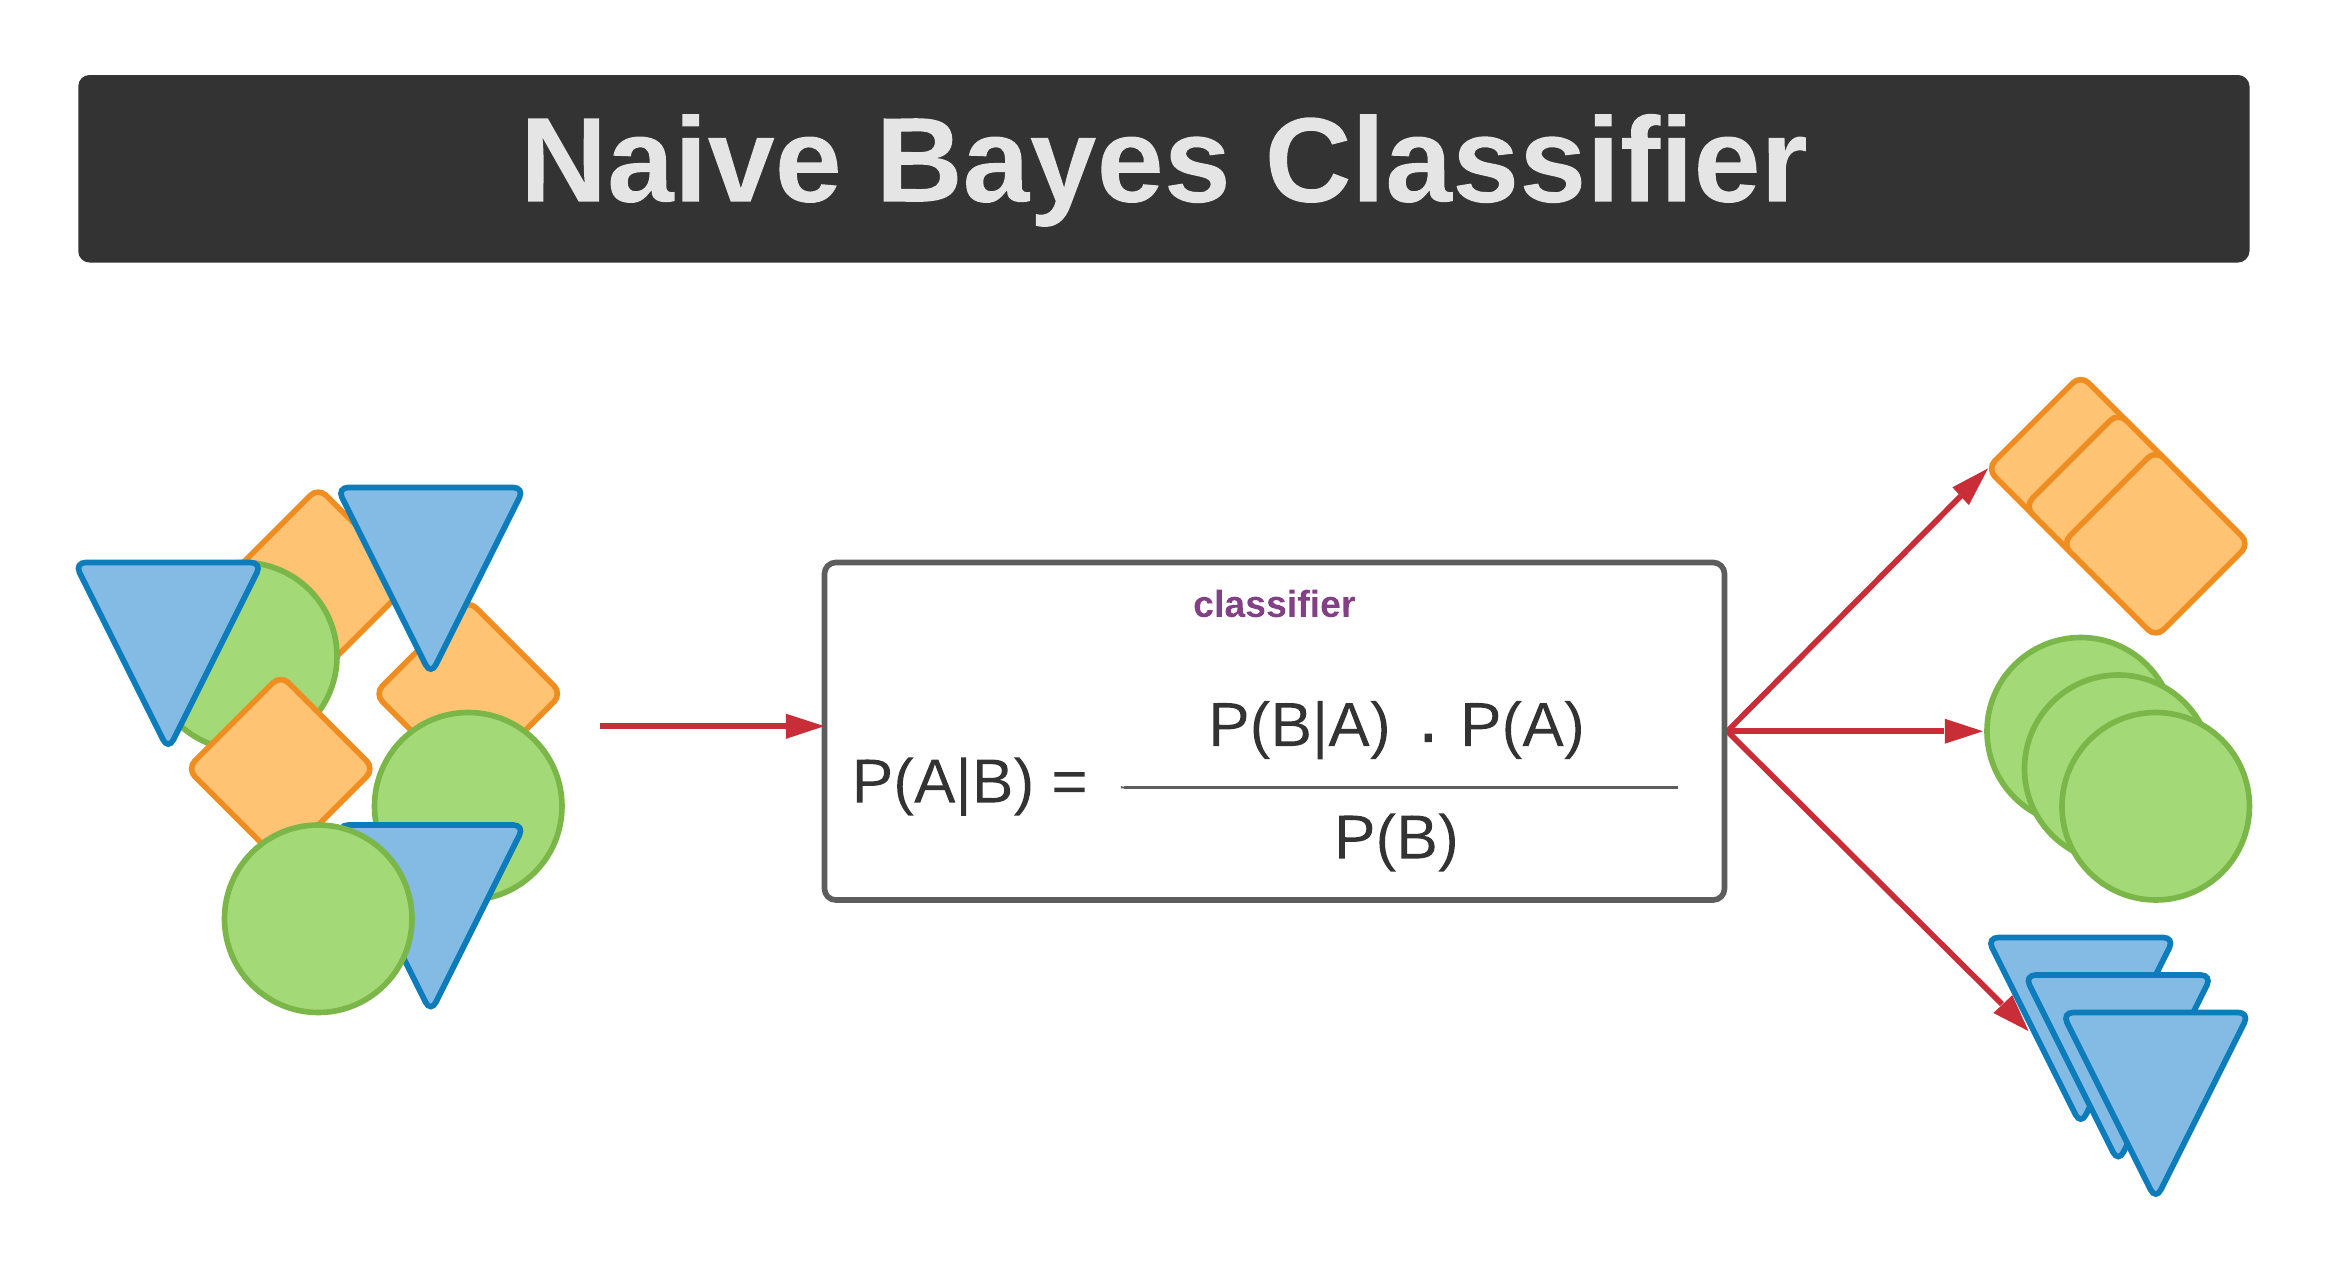

In [ ]:
clf_NB = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB, train_vectors, train["target"], cv=5, scoring="f1")
scores

In [ ]:
clf_NB.fit(train_vectors, train["target"])

In [ ]:
clf_NB_TFIDF = MultinomialNB()
scores = model_selection.cross_val_score(clf_NB_TFIDF, train_tfidf, train["target"], cv=5, scoring="f1")
scores

> naive bayes 모델의 scores가 logistic regression model 보다 더 좋게 나왔다.

In [ ]:
clf_NB_TFIDF.fit(train_tfidf, train["target"])

# 6. Making the submission

In [ ]:
def submission(submission_file_path,model,test_vectors):
    sample_submission = pd.read_csv(submission_file_path)
    sample_submission["target"] = model.predict(test_vectors)
    sample_submission.to_csv("submission.csv", index=False)

In [ ]:
submission_file_path = "../input/nlp-getting-started/sample_submission.csv"
test_vectors = test_tfidf
submission(submission_file_path,clf_NB_TFIDF,test_vectors)